In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [51]:
import re
from typing import Final, Sequence, TypeAlias

import numpy as np
import pandas as pd
from IPython.display import display
from nltk.corpus import gutenberg
from pandas import DataFrame

from authorship_tool.types_ import AuthorColl4dStr, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import dim_reshaper
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import trainer as trainer

In [4]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [6]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: AuthorColl4dStr = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [514]:
AUTHOR_A: Final[str] = "bible"
AUTHOR_B: Final[str] = "bryant"
PARAGRAPH_INIT_INDEX: Final[int] = 10
PARAGRAPH_END_INDEX: Final[int] = 1194

In [515]:
books_a: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]

paras_a: Doc3dStr = [para for paras in books_a for para in paras][
    PARAGRAPH_INIT_INDEX:PARAGRAPH_END_INDEX
]

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

1 : 8 And God called the firmament Heaven . And the evening and the morning were the second day .
1 : 9 And God said , Let the waters under the heaven be gathered together unto one place , and let the dry land appear : and it was so .
1 : 10 And God called the dry land Earth ; and the gathering together of the waters called he Seas : and God saw that it was good .
1 : 11 And God said , Let the earth bring forth grass , the herb yielding seed , and the fruit tree yielding fruit after his kind , whose seed is in itself , upon the earth : and it was so .
1 : 12 And the earth brought forth grass , and herb yielding seed after his kind , and the tree yielding fruit , whose seed was in itself , after his kind : and God saw that it was good .
1 : 13 And the evening and the morning were the third day .
1 : 14 And God said , Let there be lights in the firmament of the heaven to divide the day from the night ; and let them be for signs , and for seasons , and for days , and years : 1 : 15 And le

In [516]:
books_b: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]

paras_b: Doc3dStr = [para for paras in books_b for para in paras][
    PARAGRAPH_INIT_INDEX:PARAGRAPH_END_INDEX
]

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

" Who is there ?" she said .
The same soft little voice answered , " It ' s the Rain , and I want to come in !"
" No , you can ' t come in ," said the little Tulip .
Then it was very still for a long time . At last , there came a little rustling , whispering sound , all round the window : _rustle , whisper , whisper_ .
" Who is there ?" said the little Tulip .
" It ' s the Sunshine ," said a little , soft , cheery voice , " and I want to come in !"
" N -- no ," said the little Tulip , " you can ' t come in ." And she sat still again .
Pretty soon she heard the sweet little rustling noise at the keyhole .
" Who is there ?" she said .
" It ' s the Sunshine ," said the cheery little voice , " and I want to come in , I want to come in !"
" No , no ," said the little Tulip , " you cannot come in ."
By and by , as she sat so still , she heard _tap , tap , tap_ , and _rustle , whisper , rustle_ , up and down the window - pane , and on the door and at the keyhole .
" _Who is there ? _ " she sa

In [517]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")

total: 2368 paragraphs (samples)


In [518]:
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)

["''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_exp', 'JJ_lim', 'JJ_pp', 'JJ_presp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [519]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

In [520]:
para_ans_pairs: Sequence[tuple[Para2dStr, bool]] = [
    (para, True) for para in paras_a
] + [(para, False) for para in paras_b]

In [521]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]

In [522]:
datasets: DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T

In [523]:
datasets.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    datasets.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    datasets[col] = datasets[col].astype(dtype)

In [524]:
# df = datasets.drop(columns="answer")
df = datasets
display(df.head(10))

,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,NN,NNP,NNPS,NNS,PDT,POS,SYM,UH,WDT,WP,WP$,WRB,answer
0,0.000000,0.0,0.000000,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,0.190476,0.095238,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
1,0.000000,0.0,0.031250,0.062500,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.031250,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
2,0.000000,0.0,0.066667,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,0.133333,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
3,0.000000,0.0,0.068182,0.022727,0.000000,0.0,0.0,0.0,0.0,0.0,0.227273,0.022727,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,True
4,0.000000,0.0,0.095238,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,0.214286,0.023810,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,0.0,True
5,0.000000,0.0,0.000000,0.071429,0.000000,0.0,0.0,0.0,0.0,0.0,0.214286,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
6,0.014286,0.0,0.142857,0.014286,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,0.014286,0.0,0.085714,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
7,0.000000,0.0,0.000000,0.030303,0.060606,0.0,0.0,0.0,0.0,0.0,0.121212,0.030303,0.0,0.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
8,0.000000,0.0,0.137255,0.039216,0.000000,0.0,0.0,0.0,0.0,0.0,0.137255,0.039216,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True
9,0.000000,0.0,0.000000,0.071429,0.000000,0.0,0.0,0.0,0.0,0.0,0.214286,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,True


In [525]:
nd_category = np.array(datasets.iloc[:, -1], dtype=bool)
display(nd_category[:5])

array([ True,  True,  True,  True,  True])

In [526]:
print(df.shape)

(2368, 23)


In [527]:
print(df.dtypes)

EX          float64
FW          float64
IN          float64
JJ          float64
JJR         float64
JJS         float64
JJ_exp      float64
JJ_lim      float64
JJ_pp       float64
JJ_presp    float64
NN          float64
NNP         float64
NNPS        float64
NNS         float64
PDT         float64
POS         float64
SYM         float64
UH          float64
WDT         float64
WP          float64
WP$         float64
WRB         float64
answer         bool
dtype: object


In [528]:
print(df.isna().sum())

EX          0
FW          0
IN          0
JJ          0
JJR         0
JJS         0
JJ_exp      0
JJ_lim      0
JJ_pp       0
JJ_presp    0
NN          0
NNP         0
NNPS        0
NNS         0
PDT         0
POS         0
SYM         0
UH          0
WDT         0
WP          0
WP$         0
WRB         0
answer      0
dtype: int64


In [529]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EX        2368 non-null   float64
 1   FW        2368 non-null   float64
 2   IN        2368 non-null   float64
 3   JJ        2368 non-null   float64
 4   JJR       2368 non-null   float64
 5   JJS       2368 non-null   float64
 6   JJ_exp    2368 non-null   float64
 7   JJ_lim    2368 non-null   float64
 8   JJ_pp     2368 non-null   float64
 9   JJ_presp  2368 non-null   float64
 10  NN        2368 non-null   float64
 11  NNP       2368 non-null   float64
 12  NNPS      2368 non-null   float64
 13  NNS       2368 non-null   float64
 14  PDT       2368 non-null   float64
 15  POS       2368 non-null   float64
 16  SYM       2368 non-null   float64
 17  UH        2368 non-null   float64
 18  WDT       2368 non-null   float64
 19  WP        2368 non-null   float64
 20  WP$       2368 non-null   floa

In [530]:
author_a_df: DataFrame = datasets.query("answer == True")
author_b_df: DataFrame = datasets.query("answer == False")

In [531]:
author_a_df["JJ_lim"].describe()

count    1184.000000
mean        0.000053
std         0.001816
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.062500
Name: JJ_lim, dtype: float64

In [532]:
author_b_df["JJ_lim"].describe()

count    1184.000000
mean        0.001060
std         0.004955
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.066667
Name: JJ_lim, dtype: float64

<Axes: >

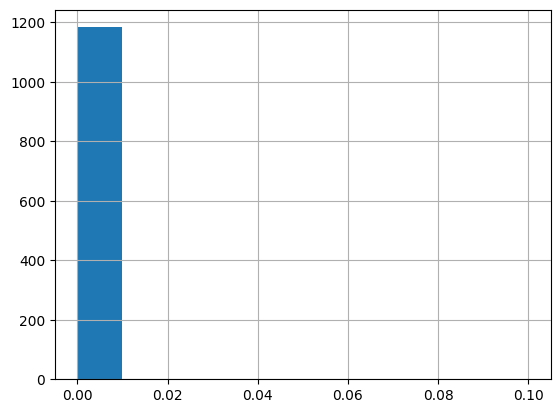

In [533]:
author_a_df["JJ_lim"].hist(range=(0, 0.1), bins=10)

<Axes: >

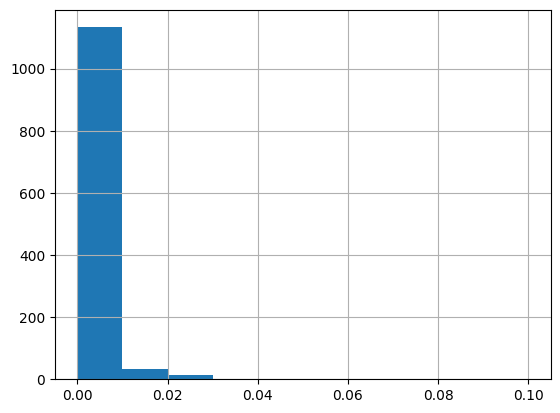

In [534]:
author_b_df["JJ_lim"].hist(range=(0, 0.1), bins=10)

In [535]:
from matplotlib import pyplot as plt
import seaborn as sns

<Axes: >

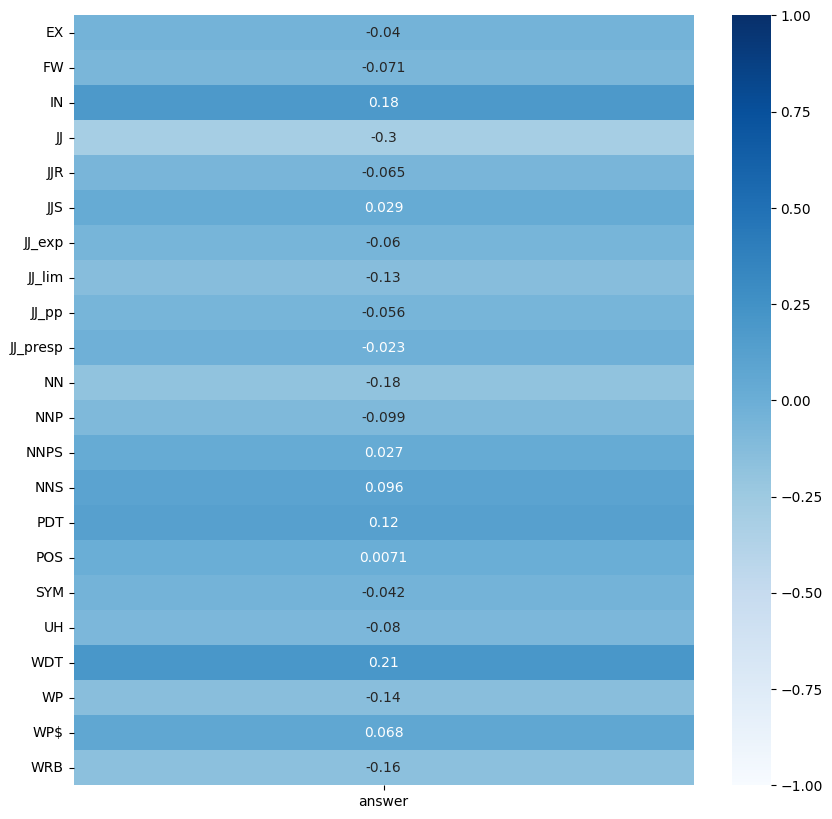

In [536]:
plt.figure(figsize=(10, 10))
datasets_corr = datasets.corr()[["answer"]].drop("answer")
sns.heatmap(datasets_corr, vmax=1, vmin=-1, center=0, annot=True, cmap="Blues")